In [1]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 384 KiB L1 22
# 1.5 MiB L2 26
# 9 MiB L3

## The programming assignment was completed in Rust 🦀!

# Implementation details for Rank/Select.

## 1. BitVec and IntVec from scratch

For constant time and truly *succinct* implementations of rank and select operations for bit vectors, I implemented my own bit vector struct `BitVec` and `IntVec` classes. Under the hood, these are just vectors of unsigned 32 bit ints. No Rust crates support bit vectors with constant time `get_int(i, w)`, `set_int(i, w, v)` function which reads or sets an int of width `w` at a given index; my implemented `BitVec` and `IntVec` classes do support these operations and hence allow "easy" implementations of the succinct data structures of interest.

## 2. Rank/Select for BitVec
I implemented a `RankSupport` struct that enables constant time rank and log time select. The constructor can be called with `RankSupport::new(bv)`.

- I represent the bits using a `BitVec.
- I represent $R_s$ and $R_b$ using bit packed `IntVec` structs with minimal wordsizes
- I call pop-count on the bit vector on blocks indexed using the implemented constant time `BitVec::get_int` method which can read off a block < 32 bits from the bit vector as a `u32` in constant time.

With the implemented `BitVec` and `IntVec` classes, I found the implementation to be relatively simple. The only technical issue I had was that Rust's *lifetime* semantics do not allow `RankSupport` to hold a reference to another struct that may be unknowingly free-ed, so the `RankSupport` struct needs to own and copy all the bits - this was a bit difficult to figure out...

## 3. Wavelet tree
The wavelet tree is represented by a matrix of $\lceil\log\sigma\rceil$ `RankSupport` structs of length $n$. U
The serial construction algorithm of Fischer, Kurpicz, and Noble is used. Serialization of the structs to disk is handled by the handy `serde` library. The serialized struct is encoded to disk using the `bincode` crate which uses at most the number of bytes required to represent the wavelet tree in memory - this is nice.

Writing the first wavelet tree operation, which was **rank** for me, was the most difficult part of the implementation. There is no mention of how to do so in the paper. Since each level in the wavelet tree is represented by a contiguous rank supported bit vector, I had to do some work to figure out how to keep track of where the pertinent intervals are during wavelet tree traversal.

The wavelet tree construction the relevant paper misses two edge cases that were not easy to identify:
1. SPos[0] needs to be set to 0 for each level. This is not explicit in the psuedocode, but is mentioned in passing in the text.
2. Incrementing counts for $Hist$ and $SPos$ can overflow bit packed int vectors of wordsize $\lceil \log n \rceil$. This needs to be accounted for when incrementing counts. This is not addressed in psuedocode.

## 4. Other fun implementation details.
1. Wavelet tree construction takes at most $O(\sigma \lceil \log n \rceil)$ space!. Wavelet Trees are built from a `WTBuilder` class that allocates two length $\sigma$ `IntVec` structs (for $Hist$ and $SPos$) with wordsize $\lceil\log(n)\rceil$.
2. The `CharTable` struct which encodes the set of ASCII chars to the minimal interval of unsigned ints requires **on the order of 128 bits - one bit per ascii character in the universe.** The implementation inserts an input character into a `RankSupport` struct and uses ranks to determine the uint used for the alphabet.
3. A wavelet tree built on `examples/dna/chr01.fsa`, the DNA sequence of the first chromosome of S. Cerevesiae, takes **less** space than the fasta file :).
4. Cargo + the rust compiler almost forces good/reasonable code. I found the built in testing framework/ecosystem to be immensely helpful :).

# Implementatin details for Wavelet Tree

# 0. Preface - BitVec implementation from scratch

For constant time and truly *succinct* implementations of rank and select operations for bit vectors, and $O(log\sigma)$ rank and $O(log(n) log\sigma)$ select operations for wavelet trees, I implemented my own bit vector struct.

Below are some benchmarks that show that the bit vector implementation is optimal!

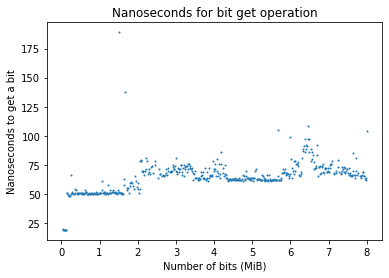

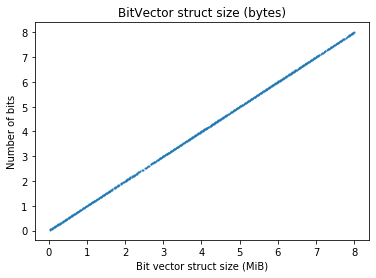

In [3]:
# 200 reps 500 samples  2^26 max
results = pd.read_csv('bv_results.txt', skiprows=4, header=None, sep='\t')
results = results[results[1] < 200]
plt.scatter(results[0] /8/ (2**20), results[1], s=1)
plt.title('Nanoseconds for bit get operation')
plt.xlabel('Number of bits (MiB)')
plt.ylabel('Nanoseconds to get a bit')

plt.show()
plt.scatter(results[0]/8/ (2**20), results[2] /8/(2**20), s=1)
plt.title('BitVector struct size (bytes)')
plt.xlabel('Bit vector struct size (MiB)')
_ = plt.ylabel('Number of bits')

Under the hood, the implemented BitVec class is a vector of unsigned 32 bit ints. Get and set operations call $O(1)$ vector gets and sets while doing the appropriate masking. So each get and set operation does *at most* 2 get/set operations for the Vec[u32] under the hood.

Observations:
1. The timing benchmarks show exactly the cache behavior we expect! The machine that ran these experiments has 300KiB, 1.5MiB, and 9MiB L1, L2, and L3 caches on the cpu - this corresponds to the steps in the plot above.
2. The space required to store the struct is indeed O(n) and optimal.

# 1. Constant time bit vector rank
A `RankSupport` class is implemented for $O(1)$.

Under the hood, $R_s$ and $R_b$ tables are implemented as bit-packed integer vectors via an implemented `IntVec` class. $R_s$ and $R_b$ tables are vectors with wordsize $log(n)$ and $loglog(n)$. $R_p$ is not represented explicitly, `RankSupport` calls a pop-count instruction to count the ones in a block.

For vectors ranging from size 0 to 70 MiB, barring measurement noise, rank operations are within +- 2 nanoseconds. Giving a strong indication that the implementation is indeed constant time, and matches the theoretical result. 

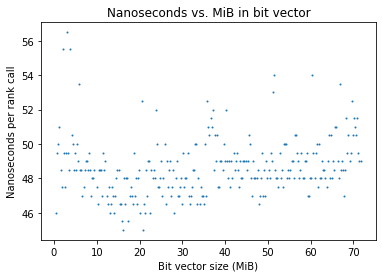

In [4]:
# 500 evenly spaced samplesfor bv size in (0, 2^30] averaged over 200 rank calls.
results = pd.read_csv('rs_results.txt', skiprows=4, header=None, sep='\t')
results = results[results[1] < 100]
plt.scatter(results[0] /8/ 2**20, results[1], s=1)
plt.title('Nanoseconds vs. MiB in bit vector')
plt.xlabel('Bit vector size (MiB)')
_= plt.ylabel('Nanoseconds per rank call')

For vectors ranging from size 0 to 8MiB, we can clearly see how caching affects the performance of the algorithm. For Bit Vectors that have a total struct size of < 1.5, where the entire data structure fits into L2 cache, the rank operation is roughly 10 % faster!

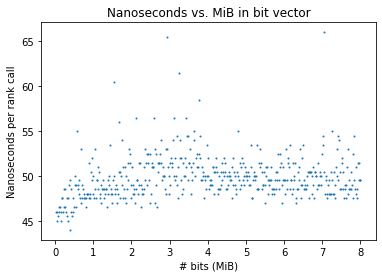

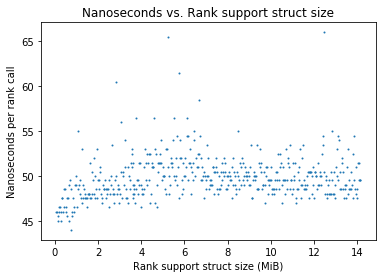

In [5]:
# 500 samples in (0, 2^26] max averaged over 200 rank calls.
results = pd.read_csv('rs_results_small.txt', skiprows=4, header=None, sep='\t')
results = results[results[1] < 100]
plt.scatter(results[0] /8/ 2**20, results[1], s=1)
plt.title('Nanoseconds vs. MiB in bit vector')
plt.xlabel('# bits (MiB)')
_= plt.ylabel('Nanoseconds per rank call')
plt.show()

plt.scatter(results[2] /8/ 2**20, results[1], s=1)
plt.title('Nanoseconds vs. Rank support struct size')
plt.xlabel('Rank support struct size (MiB)')
_= plt.ylabel('Nanoseconds per rank call')
plt.show()

Comparing the number of additional bits required to support Rank and Select operations to the number of bits stored by the RankSupport struct, we can clearly see that the overhead is $o(n)$. Thanks to actually bit-packed integer vector (`IntVec`) structs, the implemented `RankSupport` is indeed succinct. The red line is x=y, and the blue line that shows the additional bits required is clearly $o(n)$.

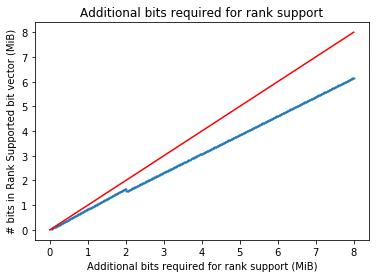

In [6]:
_max = max(results[0] /8/ 2**20)
plt.plot([0,_max], [0, _max], 'r')
plt.scatter(results[0]/8 / 2**20, (results[2]-results[0]) /8/ 2**20, s=1)
plt.title('Additional bits required for rank support')
plt.xlabel('Additional bits required for rank support (MiB)')
_= plt.ylabel('# bits in Rank Supported bit vector (MiB)')

Even for large bit vectors (~250MiB), the rank operation is just below or ~50 nanoseconds. This is a strong indication that the implementation does indeed achieve the theoretical bound. Though not an apples to apples comaprison (since different experimental runs are combined), the combined results show that the rank operation does not grow as a function of bitvector length.

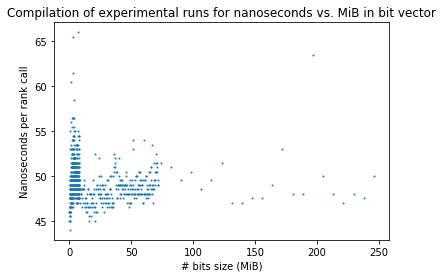

In [7]:
results = pd.concat( [pd.read_csv('rs_results.txt', skiprows=4, header=None, sep='\t'),
                      pd.read_csv('rs_results_small.txt', skiprows=4, header=None, sep='\t'),
                      pd.read_csv('rs_results_big.txt', skiprows=4, header=None, sep='\t')])
results = results[results[1] < 100]
plt.scatter(results[0] /8/ 2**20, results[1], s=1)
plt.title('Compilation of experimental runs for nanoseconds vs. MiB in bit vector')
plt.xlabel('# bits size (MiB)')
_= plt.ylabel('Nanoseconds per rank call')


# 2. O(log n) time bit vector select

Select was implemented with binary search. As expected, the select operation measures to be $O(log(n))$.

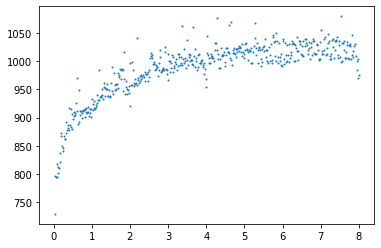

In [8]:
results = pd.read_csv('sel_results.txt', skiprows=4, header=None, sep='\t')
results = results[results[1] < 1100]
plt.scatter(results[0] /8/ 2**20, results[1], s=1)

# 3a. Constant time Wavelet Tree Rank (with fixed alphabet size)

The wavelet tree is implemented using the abovementioned `RankSupport` bit vectors. Under the hood, the bit vectors are indeed of size $n$ and the serial construction algorithm of Fischer, Kurpicz, and Noble is used.

Below, we plot the performance of the rank operation against a random ASCII strings of varying lengths. There seems to be lots of measurement noise but the measured nanoseconds per rank operation clearly does not depend on the length of the ascii string. This is evidence for constant time rank operations for fixed alphabet sizes.

Furthermore, we again plot the additional number of bytes needed versus the size of the ascii string. The implemented wavelet tree is indeed succinct and needs $o(n)$ additional bits.

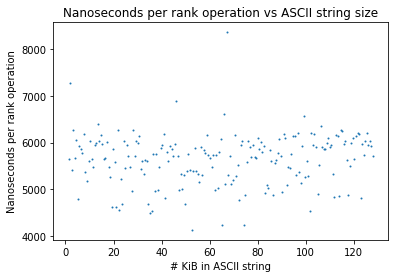

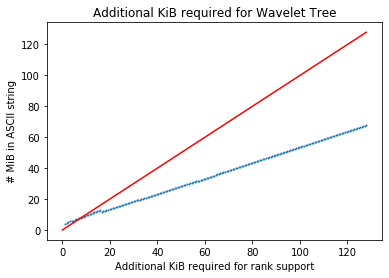

In [9]:
results = pd.read_csv('wt_rank_results.txt', skiprows=4, header=None, sep='\t')
results = results[results[1] < 12000]
plt.scatter(results[0] / 2**10, results[1], s=1)
plt.title("Nanoseconds per rank operation vs ASCII string size")
plt.ylabel("Nanoseconds per rank operation")
_= plt.xlabel('# KiB in ASCII string')
plt.show()
_max = max(results[0] / 2**10)
plt.plot([0,_max], [0, _max], 'r')
plt.scatter(results[0]/ 2**10, (results[2]-results[0]) / 2**10, s=1)
plt.title('Additional KiB required for Wavelet Tree')
plt.xlabel('Additional KiB required for rank support')
_= plt.ylabel('# MiB in ASCII string')

# 3b. O(log $\sigma$) Wavelet Tree Rank (with string length)

By measuring the time and space required for Wavelet Tree operations for a random ascii string of length 100,000 and varying alphabet size (in range [1,128]). We see that, indeed, space and time bounds for the wavelet tree are $O(log\sigma)$.

For an additional point of comparison, we plot also the number MiB of the string the wavelet tree is built on. The implemented wavelet tree, for fixed $n$, indeed takes $O(\log \sigma)$ space.

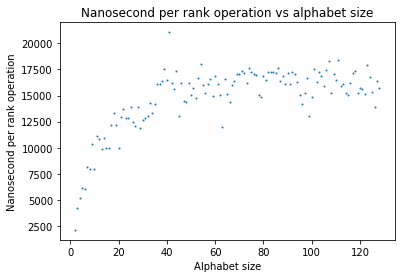

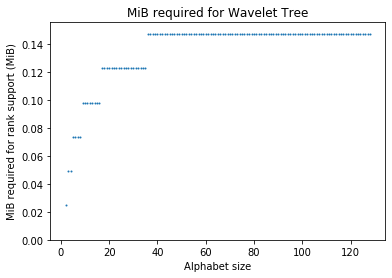

In [10]:
# WT sigma
results = pd.read_csv('wt_sigma_results.txt', skiprows=2, header=None, sep='\t')
plt.scatter(results[0], results[1], s=1)
plt.ylabel('Nanosecond per rank operation')
plt.title('Nanosecond per rank operation vs alphabet size')
_= plt.xlabel('Alphabet size')
plt.show()
plt.scatter(results[0], results[2] / (2**20), s=1)

plt.title('MiB required for Wavelet Tree')
plt.ylabel('MiB required for rank support (MiB)')
plt.ylim(0)
n_bytes = 100000 / 2**20
_= plt.xlabel('Alphabet size')

# 3c. $O(Log(n)Log(\sigma))$ time select for the wavelet tree

Wavelet tree select calls bit vector select $\log(\sigma)$ times. Below, we show nanoseconds per select for a random ascii string, which we can safely assume has $\sigma=128$ with high probability. Indeed, select on the wavelet tree is $O(\log n)$ for fixed alphabet size.

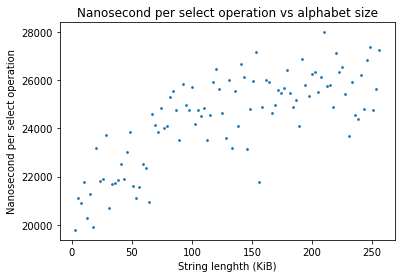

In [11]:
results = pd.read_csv('wt_select_results.txt', skiprows=3, header=None, sep='\t')
plt.scatter(results[0]/ 2**10, results[1] , s=3)
plt.ylabel('Nanosecond per select operation')
plt.title('Nanosecond per select operation vs alphabet size')
_= plt.xlabel('String lenghth (KiB)')
plt.show()

# 3c. $O(Log(\sigma))$ time rank for the wavelet tree

The implemented wavelet tree select takes constant time for fixed alphabet size. Measuring nanoseconds per access for random ascii strings show the same constant time behavior as rank.

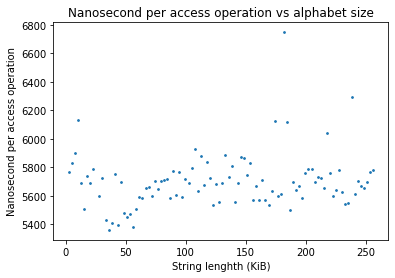

In [12]:
results = pd.read_csv('wt_access_results.txt', skiprows=3, header=None, sep='\t')
results = results[results[1] < 9000]
plt.scatter(results[0]/ 2**10, results[1] , s=3)
plt.ylabel('Nanosecond per access operation')
plt.title('Nanosecond per access operation vs alphabet size')
_= plt.xlabel('String lenghth (KiB)')
plt.show()